# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

<div class="alert alert-success">
<font size="5"><b>Комментарий ревьюера</b></font>

Успех: Вступление в работу очень важно. Так ты поясняешь то, чему она посвящена. Стоит также описать те данные, с которыми мы работаем. 

</div>

## Изучение данных из файла

In [ ]:
!pip install -U pandas

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: pandas in /home/jovyan/.local/lib/python3.7/site-packages (1.3.5)


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)


data.info()
#не поняла, почему тип object, посмотрю, какие там значения
print(data['is_apartment'].unique()) 
print(data['floors_total'].unique()) #52, 60 этаж?
print(data['floor'].unique())

display(data.head())

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Вывод

<div class="alert alert-info"> при первом взгляде на данные бросается в глаза большое количество пропусков в высоте потолков, апартаменты или нет, в жилой площади, площади кухни, наличии балкона, парков, прудов. Отсутствие пропусков в апартаментах возможно объяснить тем, что это не апартаменты, поэтому значение осталось незаполненным. 
Высота потолков: отсутствие значение означает, что человек не знал, какой высоты потолок. Справедливости ради могу отметить, что высота потолка довольно редко встречается в объявлениях, застройка типовая, все подчинено ГОСТам и СНИПам. 
Отсутвие значений в площади: жилой и кухни. Достаточно проблематично заполнить пропуски. Если ориентироваться на минимальные значения согласно ГОСТ, то насколько это в принципе нас приблизит к истине? И как это провернуть?

</div>


## Предобработка данных

заполняем пропуски ceiling_height, living_area, kitchen_area мединанным значением, 
хотя разница между средним и медианным не очень большая

думаю, что можно запонлнить пропуски в количестве этажей 1, т.к. этажность является важным ценообразущим фактором 
и можно предположить, что его отсутствие означает единственный этаж

поменяем тип числа в этажности на целое число

In [ ]:
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


In [ ]:
data['kitchen_area'].describe()

count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

In [ ]:
print(data.isna().sum())
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data['balcony'] = data['balcony'].fillna(0)
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].mean())
data['living_area'] = data['living_area'].fillna(data['living_area'].mean())
data['floors_total'] = data['floors_total'].fillna(1)
data['floors_total'] = data['floors_total'].astype('int')
#print(data.groupby('floors_total')['floor'].count())
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64
total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment            20924
studio                     

## Расчёты и добавление результатов в таблицу

In [ ]:
#добавим цену кв.м
data['sq_m_price'] = data['last_price'] / data['total_area']
data['sq_m_price'].describe()


count    2.369900e+04
mean     9.942166e+04
std      5.030680e+04
min      1.118349e+02
25%      7.658547e+04
50%      9.500000e+04
75%      1.142563e+05
max      1.907500e+06
Name: sq_m_price, dtype: float64

In [ ]:

#поработаем с датой
data['date'] = pd.to_datetime(data['first_day_exposition'], format='%Y.%m.%dT%H:%M:%S')
data['month'] = pd.DatetimeIndex(data['date']).month_name()
data['year'] = pd.DatetimeIndex(data['date']).year
data['day_of_week'] = pd.DatetimeIndex(data['date']).day_name()

#этажи

def floor_categories(row):
    floor = row['floor']
    category = row['floors_total']
    
    if floor == 1:
        return 'Первый'
    elif floor == category:
        return 'Последний'
    else:
        return 'Другое'
data['floor_final'] = data.apply(floor_categories, axis=1)
#row_values = ['1', '10']
#row_columns = ['floor', 'floors_total']
#row = pd.Series(data=row_values, index=row_columns)
#print(floor_absolute(row))
print(data['floor_final'].value_counts())

#добавим соотношение жилой к общей площади
data['living_total'] =  data['living_area'] / data['total_area']

#добавим соотношение кухни к общей площади
data['kitchen_total'] =  data['kitchen_area'] / data['total_area']
display(data.head())


Другое       17446
Последний     3336
Первый        2917
Name: floor_final, dtype: int64


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,sq_m_price,date,month,year,day_of_week,floor_final,living_total,kitchen_total
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16,51.000000,8,NaN,...,755.0,NaN,120370.370370,2019-03-07,March,2019,Thursday,Другое,0.472222,0.231481
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.65,11,18.600000,1,NaN,...,NaN,81.0,82920.792079,2018-12-04,December,2018,Tuesday,Первый,0.460396,0.272277
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.65,5,34.300000,4,NaN,...,574.0,558.0,92785.714286,2015-08-20,August,2015,Thursday,Другое,0.612500,0.148214
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14,34.457852,9,NaN,...,234.0,424.0,408176.100629,2015-07-24,July,2015,Friday,Другое,0.216716,0.066477
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14,32.000000,13,NaN,...,48.0,121.0,100000.000000,2018-06-19,June,2018,Tuesday,Другое,0.320000,0.410000


## Исследовательский анализ данных

#data['ceiling_height'].unique()
#итак, у нас есть значения, которые больше нормального, надо что-то сделать; 
#максимальная высота потолка в новостройках - 3,2 м, в старых домах - более 4, но вряд ли 10
#print(data.query('ceiling_height >= 10'))
в принципе их не так много, скорее всего ошибка, но считаю, что они не сильно влияют на общую картину

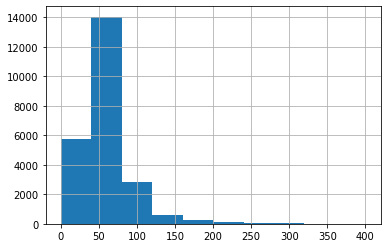

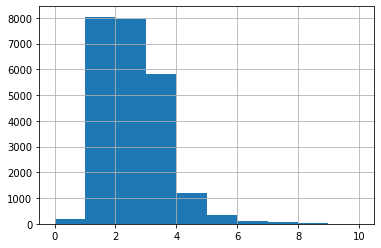

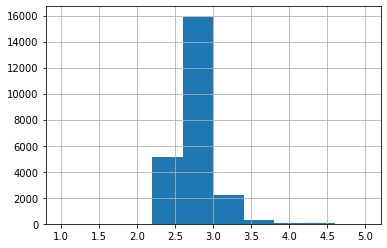

In [ ]:
#Изучите следующие параметры: площадь, цена, число комнат, высота потолков. 
#Постройте гистограммы для каждого параметра.

data['total_area'].hist(range=(0,400))
plt.show()
data['rooms'].hist(range=(0,10))
plt.show()
data['ceiling_height'].hist(range=(1,5))
plt.show()

In [ ]:
data['last_price'].describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

In [ ]:
data['last_price_mln'] = data['last_price'] / 1000000
data['last_price_mln'].describe()

count    23699.000000
mean         6.541549
std         10.887013
min          0.012190
25%          3.400000
50%          4.650000
75%          6.800000
max        763.000000
Name: last_price_mln, dtype: float64

самая дорогая квартира - 763 млн, сильно выбивается из всего списка

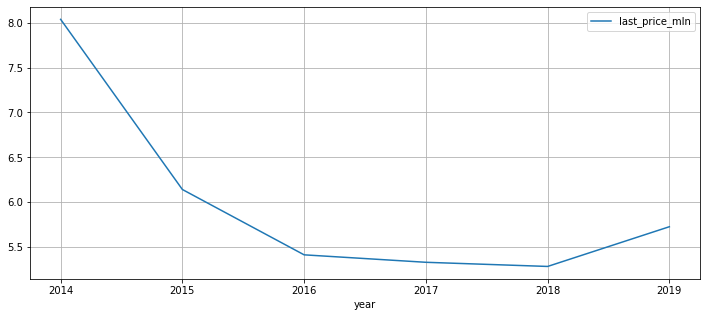

In [ ]:
data.query('last_price_mln <= 20').pivot_table(index='year', values='last_price_mln', aggfunc='mean').plot(grid=True, figsize=(12, 5))


самый дорогой год - 2014, в 2019 году цены опять повышаются

In [ ]:
#Выберите 10 населённых пунктов с наибольшим числом объявлений. 
#Посчитайте среднюю цену квадратного метра в этих населённых пунктах. 
#Выделите населённые пункты с самой высокой и низкой стоимостью жилья. 
#Эти данные можно найти по имени в столбце locality_name.
display(data['locality_name'].value_counts().head(10))

Санкт-Петербург      15721
посёлок Мурино         522
посёлок Шушары         440
Всеволожск             398
Пушкин                 369
Колпино                338
посёлок Парголово      327
Гатчина                307
деревня Кудрово        299
Выборг                 237
Name: locality_name, dtype: int64

In [ ]:
data_spb = data[data['locality_name'] == 'Санкт-Петербург']
print('Спб', data_spb['sq_m_price'].mean())

data_murino = data[data['locality_name'] == 'посёлок Мурино']
print('Мурино', data_murino['sq_m_price'].mean())

data_shush = data[data['locality_name'] == 'посёлок Шушары']
print('Шушары', data_shush['sq_m_price'].mean())

data_vsev = data[data['locality_name'] == 'Всеволожск']
print('Всеволожск', data_vsev['sq_m_price'].mean())

data_pushkin = data[data['locality_name'] == 'Пушкин']
print('Пушкин', data_pushkin['sq_m_price'].mean())

data_kolpino = data[data['locality_name'] == 'Колпино']
print('Колпино', data_kolpino['sq_m_price'].mean())

data_pargo = data[data['locality_name'] == 'посёлок Парголово']
print('Парголово', data_pargo['sq_m_price'].mean())

data_gatchina = data[data['locality_name'] == 'Гатчина']
print('Гатчина', data_gatchina['sq_m_price'].mean())

data_kudrovo = data[data['locality_name'] == 'деревня Кудрово']
print('Кудрово', data_kudrovo['sq_m_price'].mean())

data_vyborg = data[data['locality_name'] == 'Выборг']
print('Выборг', data_vyborg['sq_m_price'].mean())

Спб 114849.00879387381
Мурино 85752.18919485985
Шушары 78677.3642167513
Всеволожск 68654.4739860316
Пушкин 103125.81929072196
Колпино 75424.57909803945
Парголово 90175.91345801107
Гатчина 68746.14676333922
Кудрово 92473.54757579972
Выборг 58141.90915331862


самый дорогой - Санкт-Петербург; дешевый - Выборг

In [ ]:
#Изучите время продажи квартиры. Постройте гистограмму. 
#Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. 
#Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

data['days_exposition'].describe()

#1 день - это очень быстро, 1580 дней - это как-то слишком долго, но реально?


count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

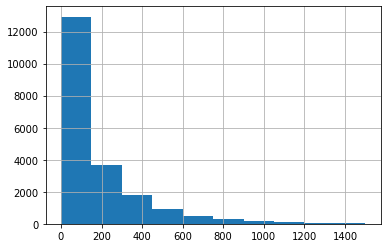

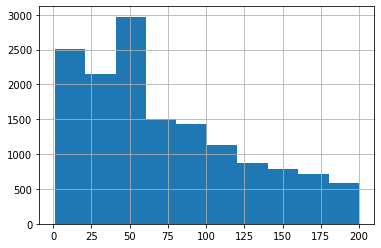

In [ ]:
data['days_exposition'].hist(range=(0, 1500))
plt.show()
data['days_exposition'].hist(range=(1, 200))
plt.show()

большинство квартир продается в промежутке от 75 до 100 дней

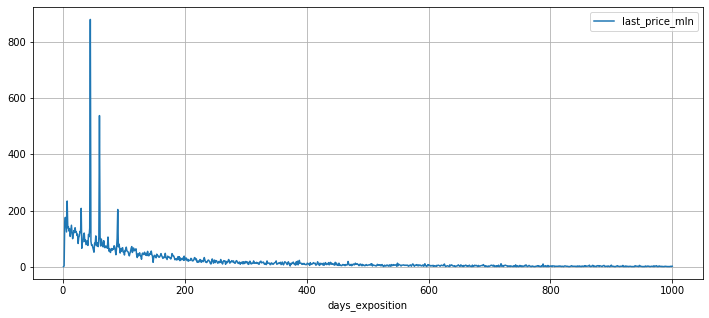

In [ ]:
data.query('days_exposition <= 1000').pivot_table(index='days_exposition', values='last_price_mln', aggfunc='count').plot(grid=True, figsize=(12, 5))

большинство квартир продаются в течение менее 200 дней

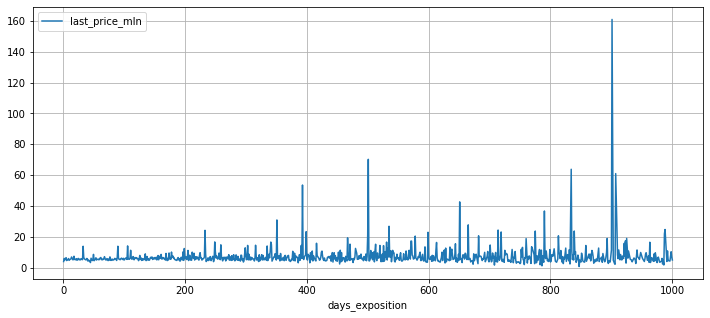

In [ ]:
data.query('days_exposition <= 1000').pivot_table(index='days_exposition', values='last_price_mln', aggfunc='mean').plot(grid=True, figsize=(12, 5))

самая дорогая квартира провисела в объявлениях 3 года

(0, 1600)

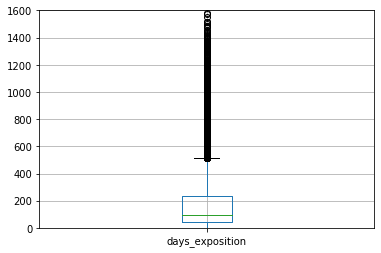

In [ ]:
import matplotlib.pyplot as plt
data.boxplot('days_exposition')
plt.ylim(0, 1600)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb1b99e5110>]],
      dtype=object)

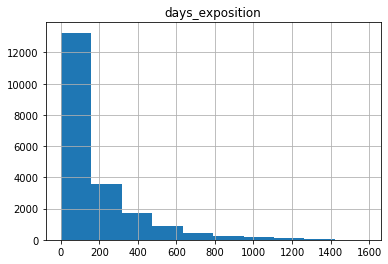

In [ ]:
data.hist('days_exposition')

большая часть значений лежит в промежутке до 200 дней

получается, что все значения, которые лежат после верхнего уса - выбросы, я думаю, что можно отбросить значения, что больше 800?

(0, 100)

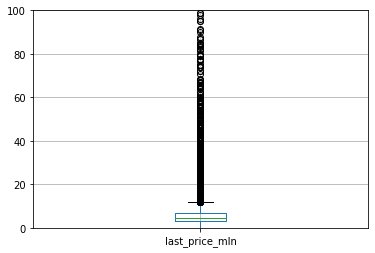

In [ ]:
data.boxplot('last_price_mln')
plt.ylim(0, 100)

<div class="alert alert-info">
 значений приходится в промежуток от 4 до млн, можно ли отбросить все, что больше 50?</div>

(0, 300)

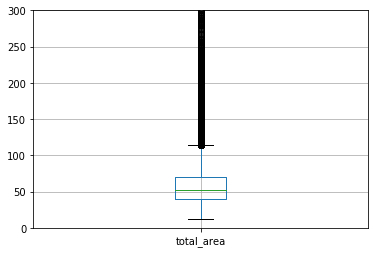

In [ ]:
data.boxplot('total_area')
plt.ylim(0, 300)

<div class="alert alert-info"> большинство значений находится в промежутке от 40 до 70, можем считать за выбросы все, что больше 150? </div>

(0, 6)

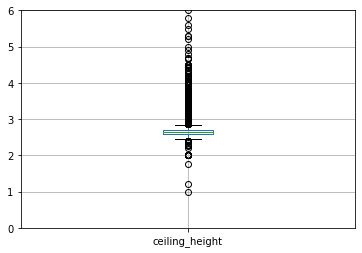

In [ ]:
data.boxplot('ceiling_height')
plt.ylim(0,6)

<div class="alert alert-info">высота потолков от 2 до 3 метров в основном количестве значений, но т.к. в старых домах возможно высота и больше 4 м, то за выбросы примем все, что больше 5 </div>

(0, 10)

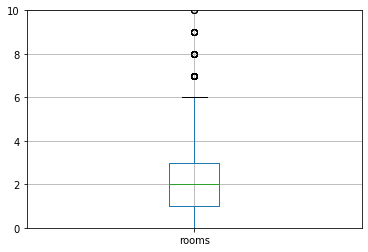

In [ ]:
data.boxplot('rooms')
plt.ylim(0,10)

<div class="alert alert-info">большинство значений в промежутке от 1 до 3, выбросы - все, что больше 8</div>

In [ ]:
filtered_data = data.query('days_exposition < 800 and last_price_mln < 50 and total_area < 150 and ceiling_height < 5 and rooms < 8')

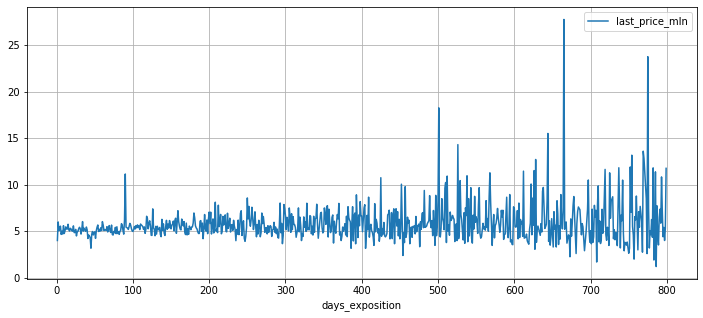

In [ ]:
filtered_data.pivot_table(index='days_exposition', values='last_price_mln', aggfunc='mean').plot(grid=True, figsize=(12, 5))

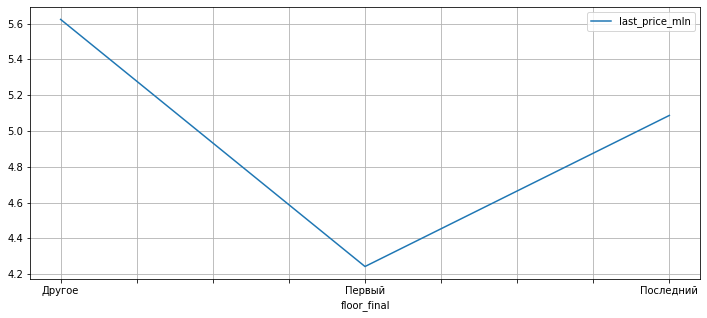

In [ ]:
filtered_data.pivot_table(index='floor_final', values='last_price_mln', aggfunc='mean').plot(grid=True, figsize=(12, 5))

<div class="alert alert-info">при фильтрации данных получилось, что в выбросах оказались самые дорогие квартиры на последнем этаже</div>

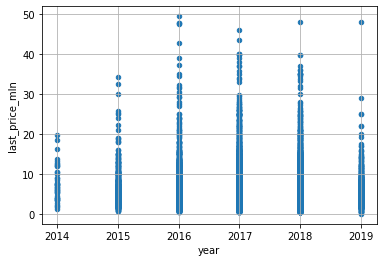

In [ ]:
filtered_data.plot(x='year', y='last_price_mln', kind='scatter', grid=True)

<div class="alert alert-info">при фильтрации данных максимальные значения показывает 2016 год</div>

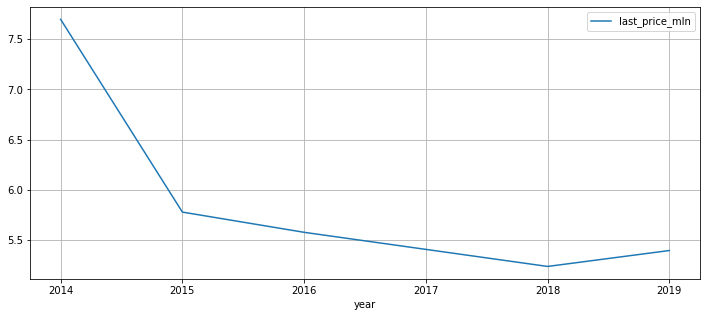

In [ ]:
filtered_data.pivot_table(index='year', values='last_price_mln', aggfunc='mean').plot(grid=True, figsize=(12, 5))

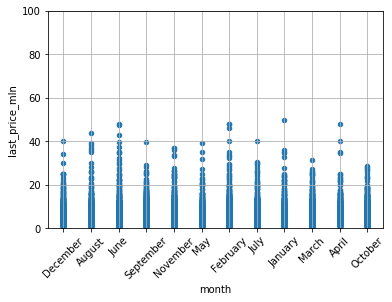

In [ ]:

filtered_data.plot(x='month', y='last_price_mln', kind='scatter', grid=True, ylim=(0,100), rot=45)

<div class="alert alert-info">максимальные значения у объявлений, которые были в январе, минимальные - в октябре</div>

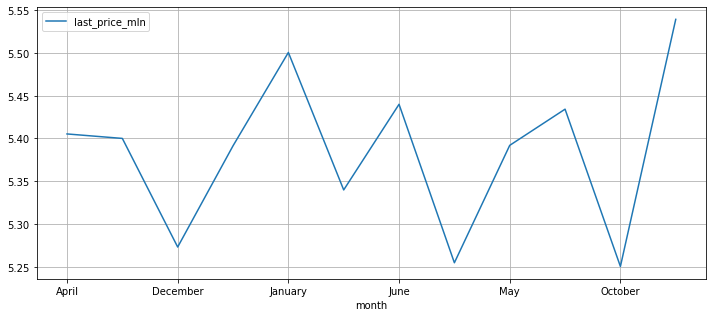

In [ ]:
filtered_data.pivot_table(index='month', values='last_price_mln', aggfunc='mean').plot(grid=True, figsize=(12, 5))

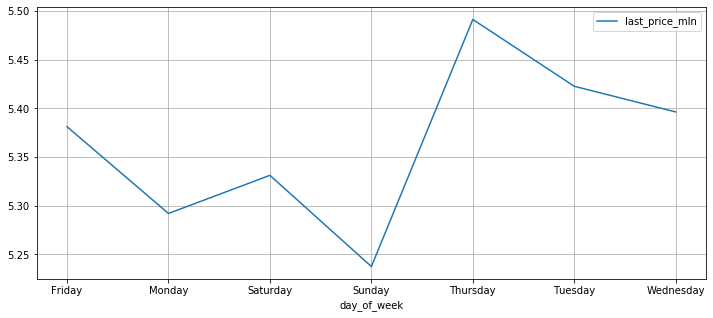

In [ ]:
filtered_data.pivot_table(index='day_of_week', values='last_price_mln', aggfunc='mean').plot(grid=True, figsize=(12, 5))

<div class="alert alert-info">максимальные значения у объявлений, поданных в четверг, минимальные - в воскресенье</div>

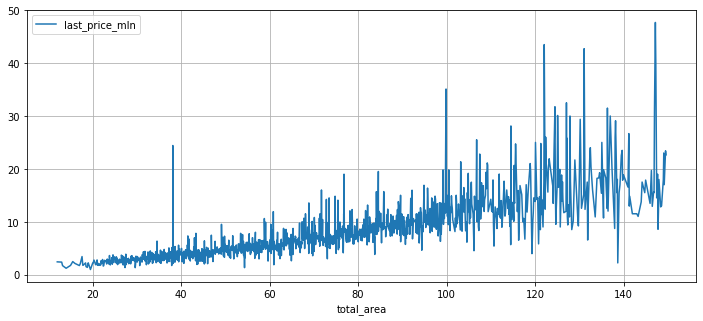

In [ ]:
filtered_data.pivot_table(index='total_area', values='last_price_mln', aggfunc='mean').plot(grid=True, figsize=(12, 5))

о как интересно, какая-то квартира до 40 кв.м выбивается; в целом, чем больше площадь, тем дороже

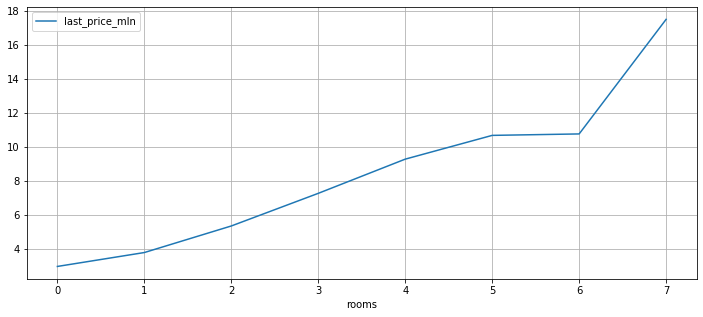

In [ ]:
filtered_data.pivot_table(index='rooms', values='last_price_mln', aggfunc='mean').plot(grid=True, figsize=(12, 5))

In [ ]:
print(filtered_data.corr())

                     total_images  last_price  total_area     rooms  \
total_images             1.000000    0.156431    0.119006  0.085310   
last_price               0.156431    1.000000    0.731916  0.440415   
total_area               0.119006    0.731916    1.000000  0.795282   
rooms                    0.085310    0.440415    0.795282  1.000000   
ceiling_height           0.041074    0.373230    0.332027  0.150101   
floors_total             0.017047    0.082195   -0.036475 -0.222499   
living_area              0.089116    0.573996    0.874331  0.841482   
floor                    0.030003    0.074629   -0.024238 -0.165847   
studio                  -0.027977   -0.052784   -0.104736 -0.165211   
open_plan               -0.022943   -0.036368   -0.065948 -0.106003   
kitchen_area             0.081197    0.525616    0.489202  0.122712   
balcony                  0.047439    0.052027    0.054132  0.000907   
airports_nearest        -0.001447   -0.038391   -0.025790 -0.051161   
cityCe

<div class="alert alert-info">есть прямая зависимость цены от от общей площади, количества комнат, жилой площади, площади кухни </div>

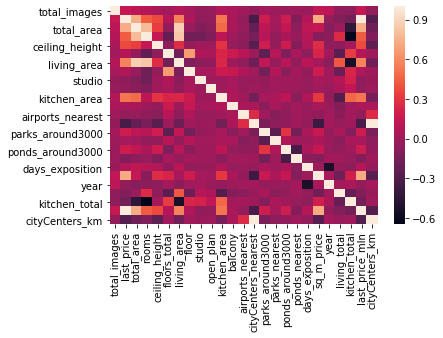

In [ ]:

sns.heatmap(filtered_data.corr())

In [ ]:
#data['cityCenters_nearest'].describe()

data['cityCenters_km'] = data['cityCenters_nearest'] / 1000
data['cityCenters_km'] = data['cityCenters_km'].fillna(data['cityCenters_km'].median())
data['cityCenters_km'] = data['cityCenters_km'].astype('int')
data['cityCenters_km'].describe()

count    23699.000000
mean        13.533060
std          7.547724
min          0.000000
25%         10.000000
50%         13.000000
75%         15.000000
max         65.000000
Name: cityCenters_km, dtype: float64

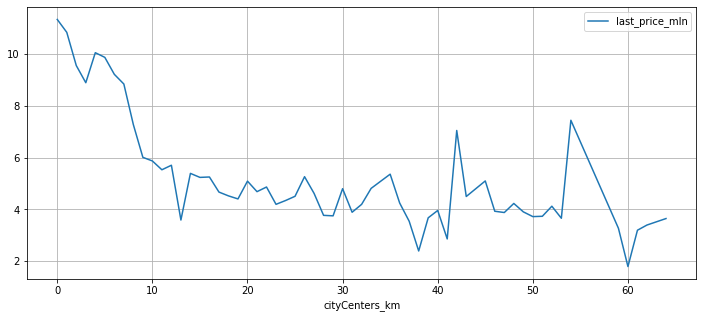

In [ ]:
filtered_data.pivot_table(index='cityCenters_km', values='last_price_mln', aggfunc='mean').plot(grid=True, figsize=(12, 5))

цена резко падает где-то в районе 12 км

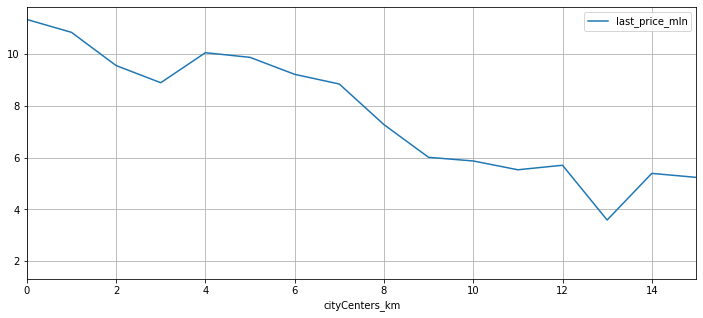

In [ ]:
filtered_data.pivot_table(index='cityCenters_km', values='last_price_mln', aggfunc='mean').plot(grid=True, xlim=(0,15), figsize=(12, 5))

In [ ]:
center_ville = filtered_data.query('cityCenters_km <= 8')


возьмем за центр 8 км радиус

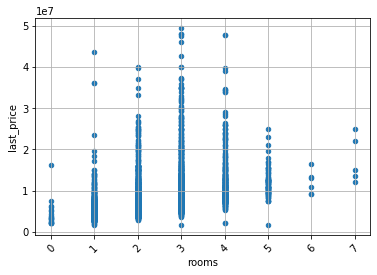

In [ ]:
center_ville.plot(x='rooms', y='last_price', kind='scatter', grid=True, rot=45)

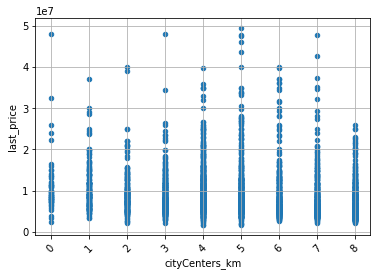

In [ ]:
center_ville.plot(x='cityCenters_km', y='last_price', kind='scatter', grid=True, rot=45)

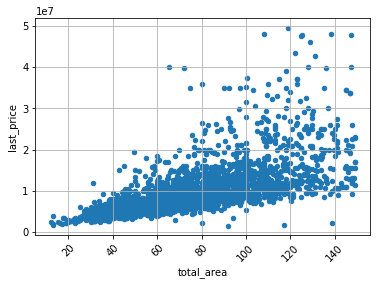

In [ ]:
center_ville.plot(x='total_area', y='last_price', kind='scatter', grid=True, rot=45)

цена увеличивается по мере увеличения площади

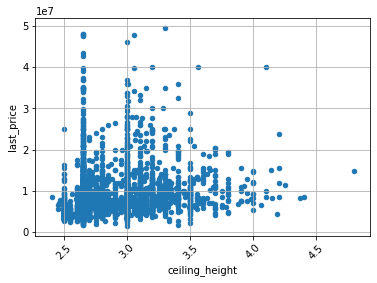

In [ ]:
center_ville.plot(x='ceiling_height', y='last_price', kind='scatter', grid=True, rot=45)

заметны большие колебания в цене по высоте потолка, но вряд ли на цену влияет высота

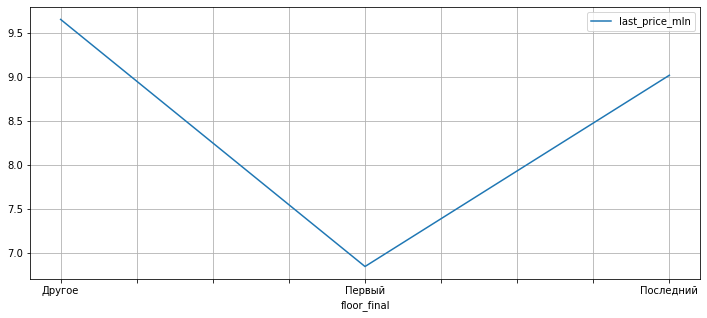

In [ ]:
center_ville.pivot_table(index='floor_final', values='last_price_mln', aggfunc='mean').plot(grid=True, figsize=(12, 5))

<div class="alert alert-info">после фильтрации данных самые дорогие значения у квартир, расположенных ни на первом, ни на последнем этажах </div>

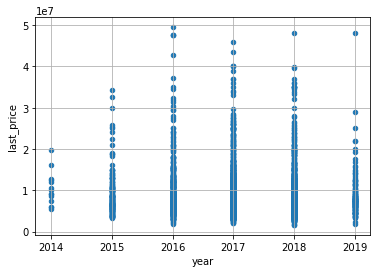

In [ ]:
center_ville.plot(x='year', y='last_price', kind='scatter', grid=True)

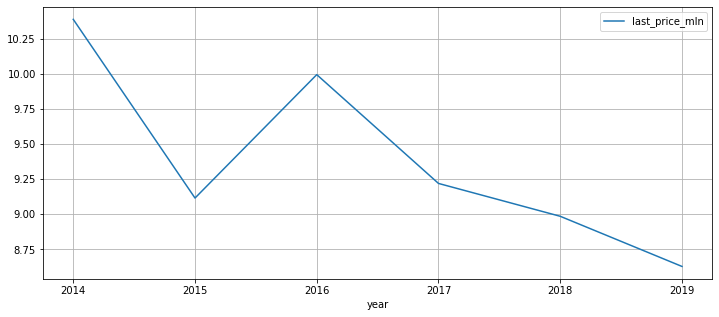

In [ ]:
center_ville.pivot_table(index='year', values='last_price_mln', aggfunc='mean').plot(grid=True, figsize=(12, 5))

самый дорогой год 2014, после 2016 года цена идет вниз

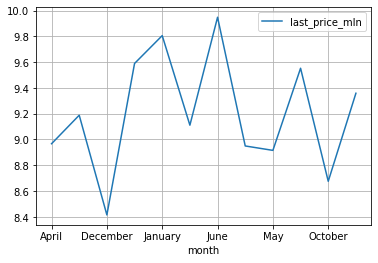

In [ ]:
center_ville.pivot_table(index='month', values='last_price_mln', aggfunc='mean').plot(grid=True)

июнь самый дорогой, декабрь дешевый

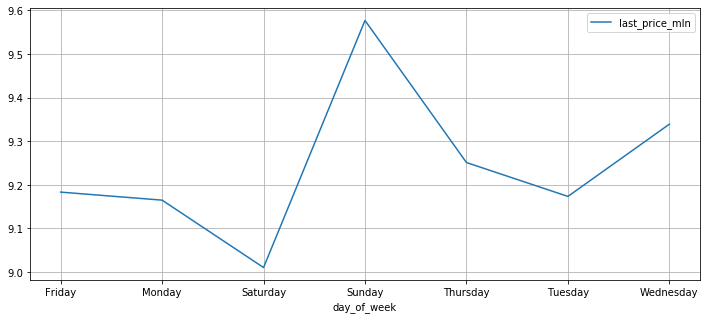

In [ ]:
center_ville.pivot_table(index='day_of_week', values='last_price_mln', aggfunc='mean').plot(grid=True, figsize=(12, 5))

воскресенье - саый дорогой день, суббота - самый дешевый

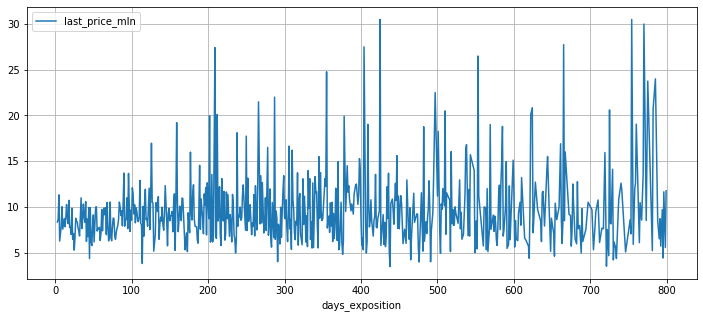

In [ ]:
center_ville.pivot_table(index='days_exposition', values='last_price_mln', aggfunc='mean').plot(grid=True, figsize=(12, 5))

количество дней не особо влияет на цену, заметные колебания в разные стороны

In [ ]:
print(center_ville.corr())

                     total_images  last_price  total_area     rooms  \
total_images             1.000000    0.167041    0.079477  0.051534   
last_price               0.167041    1.000000    0.682610  0.378034   
total_area               0.079477    0.682610    1.000000  0.781813   
rooms                    0.051534    0.378034    0.781813  1.000000   
ceiling_height           0.074933    0.174771    0.259752  0.207521   
floors_total            -0.039811    0.069813   -0.051872 -0.219665   
living_area              0.063782    0.502239    0.855888  0.812978   
floor                    0.006631    0.114736    0.021525 -0.110683   
studio                  -0.021502   -0.053057   -0.089028 -0.155067   
open_plan               -0.034309   -0.035421   -0.052479 -0.063598   
kitchen_area             0.118666    0.502301    0.464243  0.130266   
balcony                  0.031953    0.098356   -0.005518 -0.092521   
airports_nearest        -0.041180    0.014431   -0.063449 -0.095175   
cityCe

<div class="alert alert-info"> есть прямая зависимость цены от общей площади, количества комнат, площади кухни; высота потолка на цену никакого заметного влияния не оказывает</div>


## Общий вывод

<div class="alert alert-info"> Итого: был проведен анализ недвижимости Санкт-Петербурга и Ленинградской области. Выявлена прямая зависимость цены от общей площади, количества комнат, жилой площади, площади кухни. Влияние высоты потолка на цену практически отсутствует.
Недвижимостьв центре стоит дороже, чем за пределами. Ценообразующие факторы остаются такими же: общая площадь, количество комнат, жилая площадь, площадь кухни. Квартиры на 1м этаже дешевле, чем на последнем.
</div>